{
    "accuracy": 0.9749939519232884,
    "roc_auc": 0.9958323159802175,
    "precision": 0.9466971526562109,
    "recall": 0.9713353616069792,
    "f1": 0.9588580112896222,
    "true_negatives": 62165,
    "false_positives": 1492,
    "false_negatives": 782,
    "true_positives": 26499
}


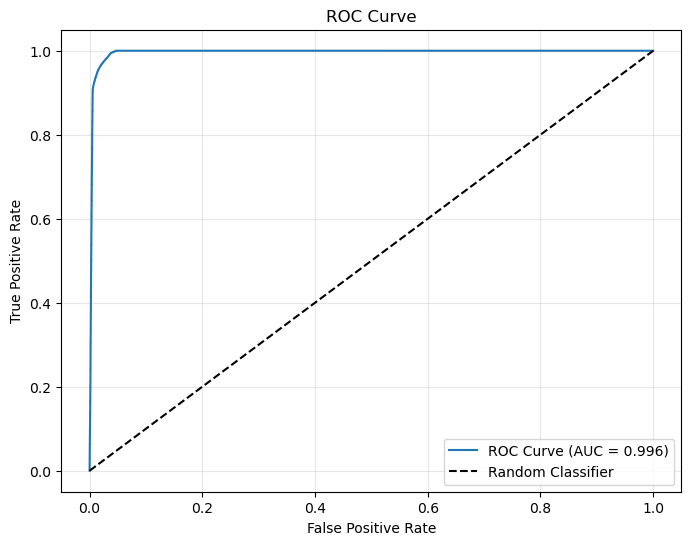

In [3]:
from MAT311.load import load_data, evaluate_model, plot_roc_curve, create_submission
import json
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier()



features = ['Age', 'Gender', 'Support Calls', 'Payment Delay', 'Contract Length', 'Total Spend']

target = "Churn"
X_train, X_test, y_train, y_test, X_submission = load_data(target, features)

model = MLPClassifier(hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.01,
    max_iter=500,
    early_stopping=True,
    random_state=42)

model.fit(X_train, y_train)

NN_p = model.predict_proba(X_test)
NN_v = model.predict(X_test)
# print(KNN_p[1])
NN_Scores = evaluate_model(y_test, NN_v, NN_p[:,1])

print(json.dumps(NN_Scores, indent=4))

plot_roc_curve(y_test, NN_p[:,1])



In [2]:
result = create_submission(model, X_submission, 11)

result.describe()

,CustomerID,Churn
count,133776.000000,1.337760e+05
mean,253147.694273,2.787868e-02
std,145702.951964,1.553662e-01
min,0.000000,3.689298e-114
25%,127106.750000,1.806221e-78
50%,253324.500000,3.330307e-53
75%,379358.500000,8.245757e-27
max,505204.000000,9.948171e-01


## First Try at Grid Search CV

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV


param_grid = {
    'alpha': np.linspace(0, 1, 10), 
    'hidden_layer_sizes': [(100,), (100,50), (50,)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=3,                
    n_jobs=-1           
)

grid.fit(X_train, y_train)
print("Best alpha:", grid.best_params_['alpha', 'hidden_layer_sizes', 'activation', 'learning_rate_init'])
print("Best score:", grid.best_score_)

Best alpha: 0.0
Best score: 0.9167994947019197


In [9]:
print("Best hidden layer sizes:", grid.best_params_['hidden_layer_sizes'])
print("alpha:", grid.best_params_['alpha'])
print("activation:", grid.best_params_['activation'])
print("learning_rate_init:", grid.best_params_['learning_rate_init'])



Best hidden layer sizes: (100, 50)
alpha: 0.0
activation: relu
learning_rate_init: 0.001


## Retrain on Full training set and test features

In [1]:
from MAT311.load import load_data, evaluate_model, plot_roc_curve, create_submission, load_data_for_validated_model
import json
from sklearn.neural_network import MLPClassifier
nn_finetuned = MLPClassifier()



features = ['Age', 'Gender', 'Support Calls', 'Payment Delay', 'Contract Length', 'Total Spend']

target = "Churn"
X_train, X_test, y_train, y_test, X_submission = load_data(target, features)

model_finetuned = MLPClassifier(hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.01,
    max_iter=500,
    early_stopping=True,
    learning_rate_init=0.001,
    random_state=42)

model_finetuned.fit(X_train, y_train)


create_submission(model_finetuned, X_submission, 10)


,CustomerID,Churn
0,262106,6.386335e-46
1,37061,2.916132e-17
2,361832,8.014323e-12
3,425516,1.138649e-57
4,60597,8.163762e-12
...,...,...
133771,396573,1.468496e-10
133772,452602,1.943982e-51
133773,424958,5.081177e-96
133774,242104,1.010357e-28


{
    "accuracy": 0.9749939519232884,
    "roc_auc": 0.9958323159802175,
    "precision": 0.9466971526562109,
    "recall": 0.9713353616069792,
    "f1": 0.9588580112896222,
    "true_negatives": 62165,
    "false_positives": 1492,
    "false_negatives": 782,
    "true_positives": 26499
}


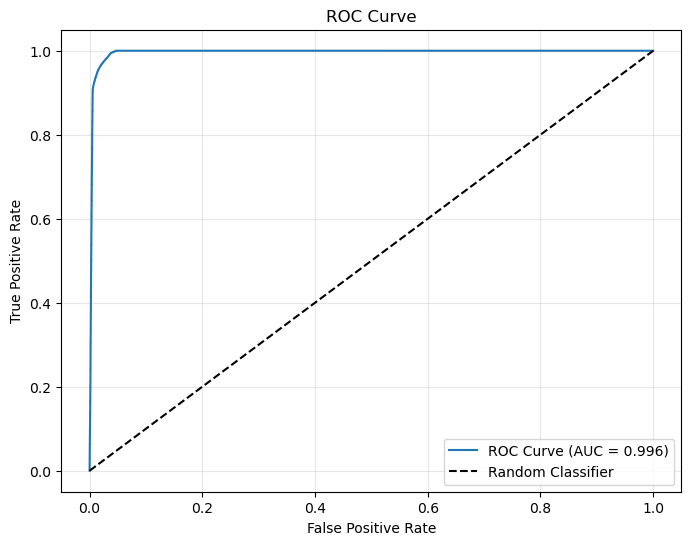

In [2]:
NN_p = model_finetuned.predict_proba(X_test)
NN_v = model_finetuned.predict(X_test)
# print(KNN_p[1])
NN_Scores = evaluate_model(y_test, NN_v, NN_p[:,1])

print(json.dumps(NN_Scores, indent=4))

plot_roc_curve(y_test, NN_p[:,1])


### Test Features

In [2]:
from sklearn.feature_selection import SequentialFeatureSelector

# Use Sequential Feature Selection instead
selector = SequentialFeatureSelector(
    estimator=model_finetuned,
    n_features_to_select='auto',  
    direction='forward',           
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)



selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

# Transform data
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

Selected features: ['Age', 'Gender_Male', 'Support Calls', 'Payment Delay', 'Contract Length_Monthly', 'Total Spend']
